## Частотный анализ звуков

Пример выделения частотных формантов из [записи](https://www.youtube.com/watch?v=2m-grMFq8bY) нашей местной райской птички. (Автор исходной записи уже удалился, но есть [похожая запись](https://www.youtube.com/watch?v=mIz022pTgEA)). [Локальная копия оригинала (доступна из класса)](http://vals/eup/mame/%D0%A9%D1%83%D1%80%D0%BA%D0%B0%20%D0%B7%D0%BE%D0%BB%D0%BE%D1%82%D0%B8%D1%81%D1%82%D0%B0%D1%8F%202%20Merops%20apiaster%20[Low,%20480x360p].mp4).

Подготовительные операции (их можно автоматизировать, но здесь описывается ручной режим)

1. Скачать видео и извлечь из него аудио, или сразу скачать аудио (если получится). Не забывайте о соблюдении авторских прав. Должно быть разрешение автора.
2. Преобразовать аудио в формат WAV 16-bit PCM - колебания в диапазоне `[-32768 +32767]`

Информация об аудио дорожке в видеофайле.
```
Audio
ID                             : 2
Format                         : AAC
Format/Info                    : Advanced Audio Codec
Format profile                 : LC
Codec ID                       : 40
Duration                       : 19s 202ms
Bit rate mode                  : Variable
Bit rate                       : 96.0 Kbps
Maximum bit rate               : 102 Kbps
Channel count                  : 2 channels
Channel positions              : Front: L R
Sampling rate                  : 44.1 KHz
Compression mode               : Lossy
Stream size                    : 225 KiB (26%)
Title                          : IsoMedia File Produced by Google, 5-11-2011
Encoded date                   : UTC 2015-03-13 13:52:49
Tagged date                    : UTC 2015-03-13 13:52:49
```

[Инструкция как установить FFMpeg](
http://manual.audacityteam.org/man/faq_installation_and_plug_ins.html#winff), чтобы открывать MP4 файлы в бесплатном редакторе [Audacity](http://www.audacityteam.org/download/).
Она же открывается при нажатии на кнопку в настройках подключения внешних библиотек.

![](audacity_codecs.png)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.signal import hilbert, periodogram, savgol_filter
from ipywidgets import interact

In [3]:
from scipy.io import wavfile
from IPython.display import YouTubeVideo, Audio, display

In [4]:
u='merops.wav'
fs,y = wavfile.read(u)
y.shape

C:\a\WinPython\python-3.5.2.amd64\lib\site-packages\scipy\io\wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(846848, 2)

Запись открылась в виде 2-х длинных последовательностей чисел - левый и правый стерео каналы.

Для расчета продолжительности записи в секундах разделим длину последовательности на частоту в переменной `fs`

In [5]:
tmax=y.shape[0]/fs
tmax

19.202902494331067

Рассмотрим данные на рисунке. Также отобразим графически разницу между каналами.

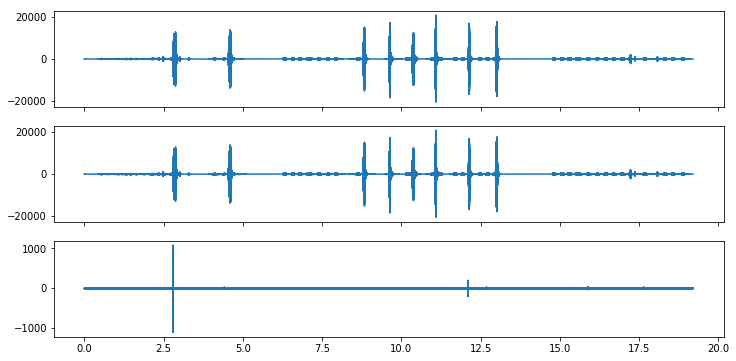

In [6]:
fig, ax = subplots(3,1, figsize=(12,6), sharex=True)
x = arange(len(y))/fs
ax[0].plot(x,y[:,0]);
ax[1].plot(x,y[:,1]);
ax[2].plot(x,diff(y));

Различия между каналами незначительны и дальше мы можем работать или с одним каналом или с их средним.

In [7]:
y = y[:,0]
y.shape

(846848,)

Визуально выделяются несколько частей - два звука с интервалом около 2 с, 6 звуков с интервалом около 1 с и еще более тихие звуки - шум.

Можно заметить, что после громких звуков шум меньше по амплитуде - это отражение динамической подстройки чувствительности микрофона при записи. То есть когда громких звуков нет - чувствительность растет до определенного уровня.

Давайте послушаем шум.

Чтобы получить позицию в массиве данных, соотвествующей заданной секунде, нужно время умножить на частоту (rate, frequency). Поскольку позиция (index) не может быть дробным числом, то преобразовываем его в целое (integer).

In [8]:
int(6.1*fs)

269010

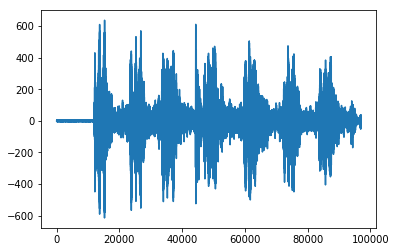

In [9]:
shum = y[int(6*fs):int(8.2*fs)]
plot(shum);
Audio(shum, rate=fs, autoplay=True)

По контуру можно различить шесть однотипных звуков, убывающих по интенсивности. Перед 4-м звуком еще один короткий резкий звук.

В засимости от того, что мы хотим изучать - полезным сигналом и шумом можно считать разные компоненты звука.

Даже там где за графике ничего не заметно - звук есть. Даже при записи полной тишины присутствуют помехи оборудования.


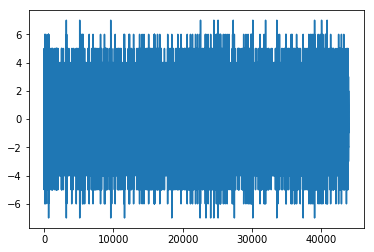

In [10]:
shum = y[230000:274000]
plot(shum);
Audio(shum, rate=fs, autoplay=True)

Давайте выберем секунду записи с самым громким звуком. Чтобы получить целое число при делении используется двойной знак деления.

In [11]:
fs/2, fs//2

(22050.0, 22050)

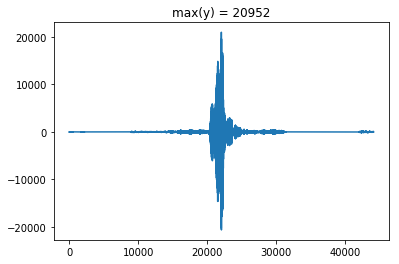

In [12]:
i = argmax(y)
signal = y[i-fs//2:i+fs//2]
plot(signal);
title('max(y) = {}'.format(max(y)));
Audio(signal, rate=fs, autoplay=True)

Если обратить внимание на ось ординат, то видно что амплитуда шума составляет около 6 (фоновых звуков ~ 600), что намного меньше максимальной амплитуды сигнала. Громкость цифрового звука задается в у.е. и реально задается регулятором громкости колонок или наушников. Громкость реальных звуков измеряют в дБ - относительно порога слышимости.

In [13]:
max(y)/array([6, 600])

array([ 3492.  ,    34.92])

1 дБ означает увеличение звукового давления в $10^{0.05}$  ≈ 1.122 раза. Относительная громкость в дБ расчитывается по [формуле](https://ru.wikipedia.org/wiki/Децибел):
$$ B = 20 \ lg_{10}\frac{F_1}{F_0}$$


In [14]:
20*log10(_)

array([ 70.8614847,  30.8614847])

Интересный звук на 18-й секунде. Он очень короткий, поэтому частотная составляющая не воспринимается.
Звук, когда происходит резкий перепад интенсивности (давления воздуха), называется *щелчок*.

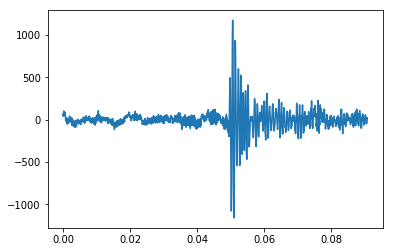

In [15]:
shum = y[795000:799000]
plot(arange(len(shum))/fs, shum);
Audio(shum, rate=fs, autoplay=True)

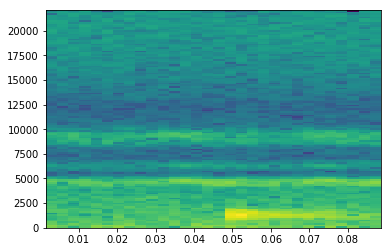

In [16]:
specgram(shum, Fs=fs);

На спектрограмме видно, что наиболее выраженный сигнал, начинающийся с 48 мс, имеет частоту около 1 кГц.

Для более точного определения частоты используют периодограммы, или в просторечии "спектр". На выходе мы получаем суммарную оценку спектральной плотности сигнала: как бы сжимаем спектрограмму по вертикали и кладем ее на бок. Рисунок по-умолчанию отображается в логарифмической шкале, дБ.

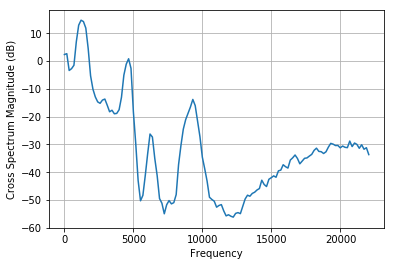

In [17]:
P, ff = csd(shum, shum, Fs=fs, scale_by_freq=True);

В обычной шкале наибольший пик значительно выше остальных.

C:\a\WinPython\python-3.5.2.amd64\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


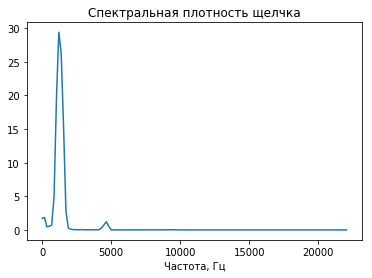

In [18]:
plot(ff,P); title('Спектральная плотность щелчка'); xlabel('Частота, Гц');

Из предупреждения следует, что значения спектральной плотности в виде комплексных чисел. Можно перевести их в дБ как на предыдущем рисунке.

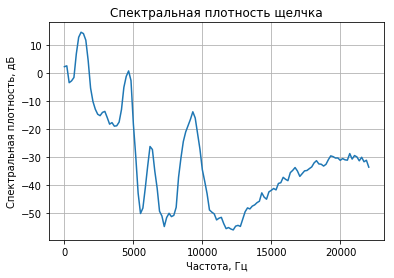

In [19]:
vv = 10*log10(real(P))
plot(ff,vv); title('Спектральная плотность щелчка'); xlabel('Частота, Гц'); ylabel('Спектральная плотность, дБ'); 
grid();

Чтобы получить частоту щелчка, нужно найти индекс максимума на этом графике, и получить значение частоты с этим же индексом.
Точность зависит от параметров сглаживания при расчете спектра.

In [20]:
ff[argmax(vv)]

1205.859375

Для автоматического выделения отдельных звуков существуют специальные библиотеки. Для понимания принципов воспользуемся инструментами, доступными в базовом пакете `scipy`.

Аналитический сигнал - это сигнал, разложенный с помощью преобразования Гильберта. Из него мы можем выделить:
- Амплитудную составляющую (отклонение на комплексной плоскости) - огибающую (envelope), которая отражает выраженность сигнала.
- Частотную составляющую (угол движения на комплексной плоскости) - мгновенную частоту.

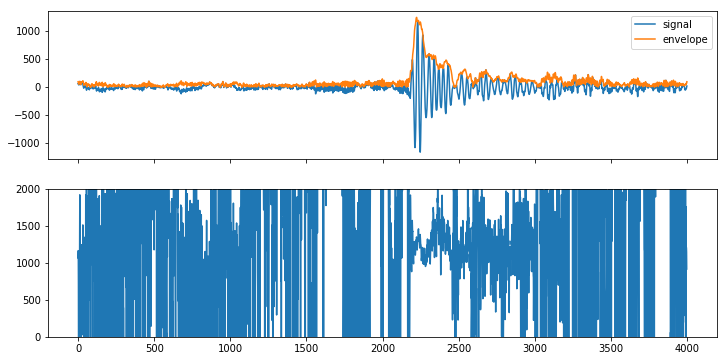

In [21]:
analytic_signal = hilbert(shum)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs

fig, (ax0, ax1) = subplots(2,1, figsize=(12,6), sharex=True)
ax0.plot(shum, label='signal')
ax0.plot(amplitude_envelope, label='envelope')
ax0.legend()
ax1.plot(instantaneous_frequency)
ylim(0, 2000);

Любые шероховатые сигналы можно сгладить фильтром.

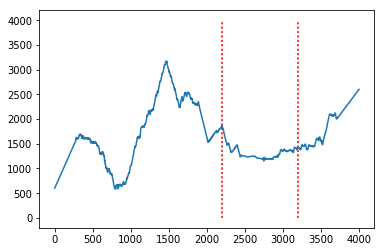

In [22]:
@interact(win=(11,1001,10), order=(1,3))
def smooth(win=301, order=1):
    plot(savgol_filter(instantaneous_frequency, win, order))
    vlines([2200, 3200], 0, 4000, color='r', linestyles=':')

Видно, что мгновенная частота в районе щелчка составляет примерно 1200. Поскольку мы все равно усредняли, то оценка по спектру более точная и удобная.

Огибающая после сглаживания может быть полезна для выделения отдельных звуков.

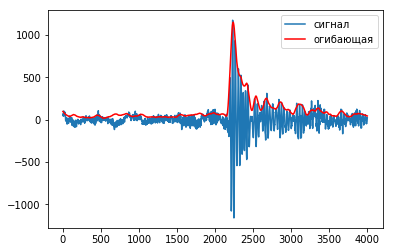

In [23]:
og = savgol_filter(amplitude_envelope, 125, 2)

plot(shum, label='сигнал')
plot(og, 'r', label='огибающая')
legend();

Повторим успех на всей записи.


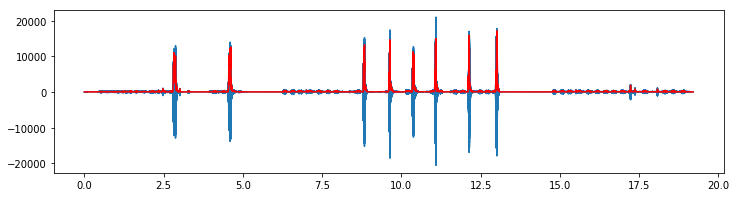

In [24]:
def ogibai(y):
    return savgol_filter(np.abs(hilbert(y)), 325, 2)
og=ogibai(y);

fig, ax = subplots(1,1, figsize=(12,3), sharex=True)
x = arange(len(y))/fs
plot(x,y);
plot(x,og,'r');


Зададим порог вполовину от максимума, или меньше, и выделим все участки сигнала превышающие порог.

Рассмотрим подробнее первый найденный участок с сигналом.

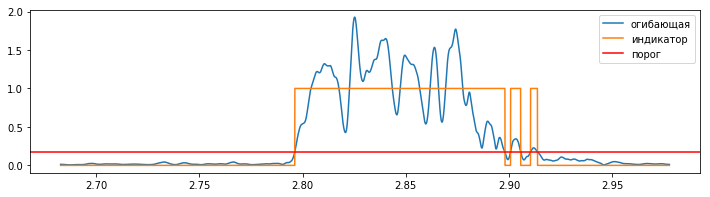

In [25]:
porog=1000
bb = og>porog
i1 = argmax(bb)

k=3 #множитель для наглядности
figsize(12,3);
ii = slice(i1-5000, i1+8000)
plot(x[ii], k*og[ii]/max(og), label='огибающая');
plot(x[ii], bb[ii], label='индикатор');
axhline(k*porog/max(og), color='r', label='порог');
legend();
# ylim(0,2);

С помощью критерия мы получили квазисигнал, который равен 1 там, где исходный сигнал выше порога и 0, где - ниже.

Можно воспринимать этот квазисигнал как индикатор двух состояний: есть сигнал / нет сигнала.

Возможны три варианта перехода между состояниями (в скобах разница между соседними точками):
1. состояние не изменилось (0).
2. появился сигнал (+1).
3. исчез сигнал (-1).

В околопороговых зонах бывают краевые эффекты - неустойчивые колебания состояния при переключении - в электротехнике называется *[дребезг](https://ru.wikipedia.org/wiki/Дребезг_контактов)*.

Найдем точки смены состояний.

In [26]:
iiab = find(diff(bb.astype(int))==1)+1
iiad = find(diff(bb.astype(int))==-1)+1
#число точек смены состояний должно совпасть!
iiab, iiad

(array([123314, 127922, 128348, 200430, 204541, 204868, 387855, 390900,
        391334, 423404, 424122, 425678, 426238, 426990, 427489, 456173,
        456992, 459171, 459913, 487345, 488010, 490090, 490981, 533790,
        534388, 536487, 537083, 572172, 572927, 574798, 575429, 575980,
        759737], dtype=int64),
 array([127802, 128137, 128496, 204410, 204766, 205205, 390557, 391253,
        391727, 424038, 425651, 426001, 426533, 427155, 427573, 456923,
        458980, 459761, 460054, 487903, 490039, 490566, 491083, 534310,
        536365, 536988, 537147, 572858, 574705, 575171, 575583, 576086,
        759916], dtype=int64))

Если между окончанием одного сигнала и началом следующего очень маленький промежуток (например, 0.2 с), то их объединяем. 

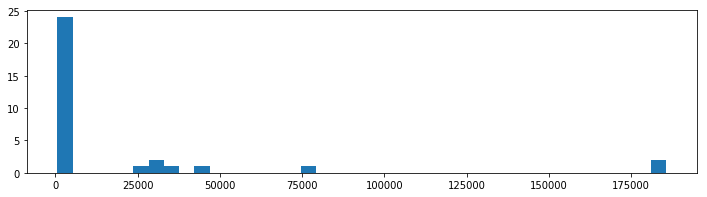

In [27]:
isi = iiad[1:]-iiab[:-1]
hist(isi, 40);

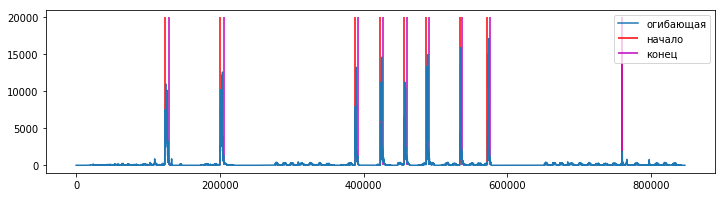

In [28]:
ii_drebezg = find(isi < fs//5)
iiab = delete(iiab ,ii_drebezg+1)
iiad = delete(iiad ,ii_drebezg)

plot(og, label='огибающая');
vlines(iiab, 0, 20000, color='r', label='начало')
vlines(iiad, 0, 20000, color='m', label='конец')
legend();

После определения положения всех обособленных звуков можно анализировать каждый из них индивидуально и сравнивать между собой.

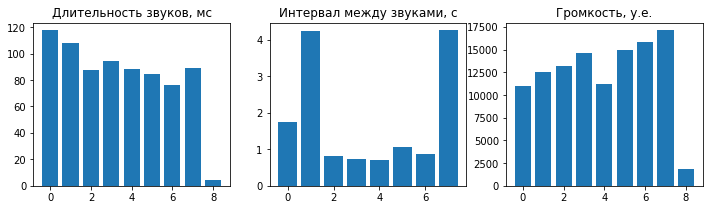

In [29]:
dd = (iiad-iiab)/fs * 1000
isi = diff(iiab+dd)/fs #между центрами звуков
#этой конструкцией мы делим сигнал на фрагменты по всем найденным индексам и считаем максимум в каждом втором
a = [max(_x) for i,_x in enumerate(split(og, sort(hstack([iiab,iiad])))) if i%2]

figsize(12,3);
subplot(131)
bar(arange(len(dd)), dd); title('Длительность звуков, мс');
subplot(132)
bar(arange(len(isi)), isi); title('Интервал между звуками, с');
subplot(133)
bar(arange(len(a)), a); title('Громкость, у.е.');

Можно отбрать интересующие нас звуки для анализа, оформить результаты в виде готового набора данных и т.д.

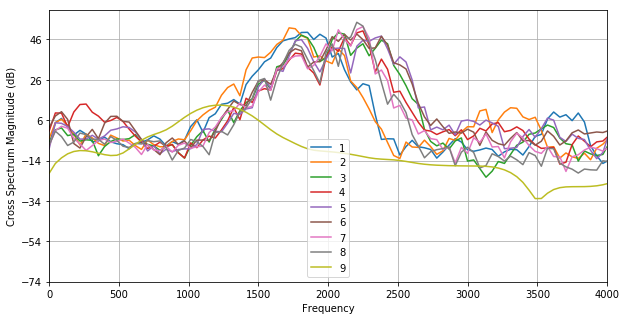

In [30]:
figsize(10,5)
for iab,iad in zip(iiab,iiad):
    y1 = y[iab:iad]
    P, ff = csd(y1, y1, NFFT=1000, Fs=fs);
    
legend(arange(len(iiab))+1);
xlim(0,4000);

На спектре видно несколько частотных пиков: 1800, 2100, 2200 Гц. 

Спектральная плотность для 1 и 2 звуков ниже, чем для остальных. В 3-, 5- и 6-м звуках есть более высокие второстепенные тоны с частой свыше 2400 Гц.

Более детальная структура звука определяет его тембр. Идеи дальнейшего анализа отдельных звуковых формантов могут появиться при анализе спектрограмм. Построим спектрограмму каждого из 8 звуков длительностью около 100 мс.

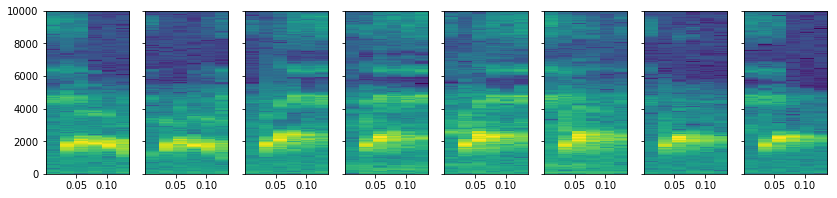

In [31]:
fig, axx = subplots(1,8, sharex=True, sharey=True, figsize=(14,3), subplot_kw=dict(xticks=[0.05,0.1]))
for i,iab in enumerate(iiab[:8]):
    axes(axx[i])
    specgram(y[iab-fs//40:iab+5600], NFFT=1000, Fs=fs, noverlap=0)
    ylim(0,10000)


Вот так можно вставить исходное видео с видеохостинга в блокнот.

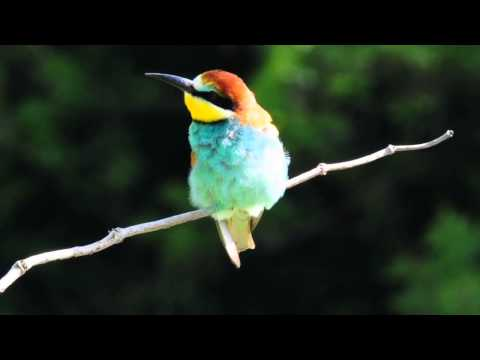

In [32]:
#YouTubeVideo('2m-grMFq8bY')